# ◈ 데이터 분석 준비

## 1) Colab 환경 설정

In [ ]:
# 시각화 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 트리맵
!pip install squarify

# 요인분석
!pip install pingouin factor_analyzer

# 연관분석
!pip install -U apyori mlxtend

## 2) 필수 라이브러리 로드

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

## 3) 글로벌 환경 설정

In [ ]:
#%precision 3 # np 정확도를 소숫점 3자리로 고정
%matplotlib inline
sns.set_theme()

# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

sns_color = sns.color_palette('pastel')
plt_cmap = ['Pastel1', 'Set2', 'Spectral']
plt_line = ['-', '--', ':', '-.']

## 4) 분석 데이터 로드

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

X = iris.data
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

# ◈ Logical Regression
- 독립, 종속 변수간 선형 관계성 기반

## 1) Statsmodel GLM

In [ ]:
import statsmodels.api as sm

model = sm.GLM(np.reshape(y_train, (-1,1)), X_train).fit()
print(model.summary())

from sklearn.preprocessing import Binarizer
y_prob = np.array(model.predict(X_test))
y_pred = Binarizer(threshold=0.5).fit_transform(np.array(y_prob).reshape(-1, 1)).ravel()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  112
Model:                            GLM   Df Residuals:                      108
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                        0.051369
Method:                          IRLS   Log-Likelihood:                 9.3642
Date:                Fri, 08 Apr 2022   Deviance:                       5.5478
Time:                        13:46:30   Pearson chi2:                     5.55
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0620      0.057     -1.096      0.2

## 2) LogisticRegressor
- solver 선택
  - small dataset: lbfgs, liblinear
  - large dataset : sag, saga       
  - non sclaed dataset : lbfgs, liblinear, newton-cg
  - dcaled dataset : sag, saga       
  - multi class : newton-cg, sag, saga

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    multi_class = 'auto', # 'ovr', 'multinomial', 'auto'
    max_iter = 100,
    solver = 'saga',
    verbose = False,
    n_jobs = -1,
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 0.98
예측 정확도 : 0.97


# ◈ Decision Tree
- 분류와 회귀에 사용되는 지도학습
- 데이터 특성으로부터 결정규칙을 추론해 값을 예측
- 트리 깊이가 깊을수록 복잡
- 장점
  - 이해와 해석,시각화 용이하고 데이터 크기가 커도 모델 구축 빠름
  - 데이터 분포에 대한 전제가 필요 없음 
  - 데이터 전처리 용이, 수치/범주 모두 취급 가능
- 단점
  - 계층구조로 중간 에러가 다음에 전파
  - 적은수의 노이즈에도 민감

## 1) DecisionTreeClassifier
- ccp_alpha : Cost Complexity Pruing 값, 
  - 지정값 이하 노드를 가지치기 하는데, 값이 커질수록 가지치기 강도가 커진다.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion = 'entropy', # 'gini', 'entropy'
    # max_depth = 5, 
    ccp_alpha = 0.2,
    # min_samples_split = 2, # default 2
    random_state=13,
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 0.96
예측 정확도 : 0.95


> 변수 중요도 확인

In [ ]:
print(f'변수 중요도 : {model.feature_importances_}')

변수 중요도 : [0.         0.         0.32642584 0.67357416]


## 2) DeciaionTree 시각화

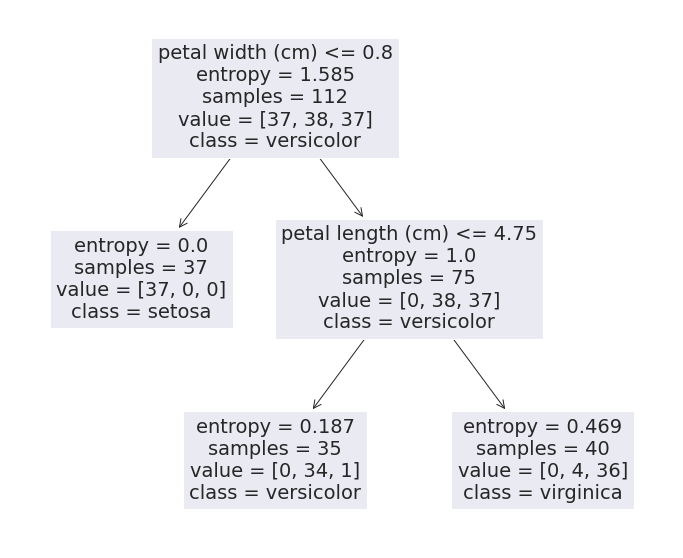

In [ ]:
from sklearn.tree import plot_tree

# 의사결정트리 도식화
plt.figure(figsize= (12,10))
plot_tree(
    model,
    feature_names = iris.feature_names,
    class_names = iris.target_names
    );

## 3) DecisionTree 최적화

In [ ]:
def plot_ccp(model, X, y):
    path = model.cost_complexity_pruning_path(X, y)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    clfs = []
    for ccp_alpha in ccp_alphas:
        clfs.append(DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha).fit(X, y))
    clfs, ccp_alphas = clfs, ccp_alphas

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ln1 = ax1.plot(ccp_alphas, [clf.tree_.node_count for clf in clfs], 'o-', 
                   color = '#66c2a5', drawstyle="steps-post", label='node count')
    ln2 = ax1.plot(ccp_alphas, [clf.tree_.max_depth for clf in clfs], 'o-', 
                   color = '#e78ac3', drawstyle="steps-post", label='depth')
    ln3 = ax2.plot(ccp_alphas, impurities, 'o--', 
                   color = '#8da0cb', drawstyle="steps-post", label='impurities')
    lns = ln1+ln2+ln3
    ax1.legend(lns, [l.get_label() for l in lns], loc='center left')
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("count")
    ax2.set_ylabel("total impurity")
    ax2.grid(False)
    plt.title('cost complexity pruning path')
    plt.show()
    return

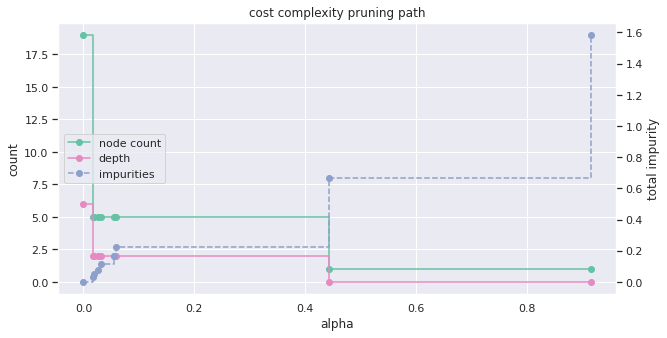

In [ ]:
plot_ccp(model, X_train, y_train)

# ◈ Ensemble 모형
- 일반화와 강건성을 위해 여러 Base 모델들의 예측을 다수결 또는 평균을 이용해 통합하여 예측 정확성을 향상
- 약한 학습기를 결합하여 확률적인 보완과 오류에 대한 가중치를 업데이트 하면서 학습
- 정형 데이터에서 특히 높은 예측 성능 발휘
- 앙상블 모델 요구조건
  - Base 모델들은 서로 독립적
  - Base 모델들이 무작위 예측 수행 모델보다 성능이 좋아야 함

## 1) Voting
- 다른 분류기 + 동일 데이터
- 서로 다른 모델들의 결과를 투표를 통해 결합
- 투표방식
  - hard voting : 다수결, 다수의 분류기가 결정한 예측값을 최종 예측값으로 선정
  - soft voting : 다수 분류기의 예측 확률을 평균내어 최종 예측값을 결정

### 가) VotingClassifier


In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(
    estimators = [
        ('svc', SVC()),
        ('tree', DecisionTreeClassifier()),
        ('niive', GaussianNB())
        ],
    voting = 'hard'
).fit(X_train, y_train)

print(f'모델 정확도: {model.score(X_train, y_train):.3f}')
print(f'예측 정확도: {model.score(X_test, y_test):.3f}')

모델 정확도: 0.982
예측 정확도: 1.000


## 2) Bagging
- Bootstrap aggregating, 동일 분류기 + 부트스트랩
- 원래 훈련 데이터셋의 일부를 사용하여 여러 모델을 훈련하여 각각의 결과를 결합해 최종 결과를 생성
- 분산을 줄이과 과적합을 제거하여 강력하고, 복잡한 모델에서도 잘 동작


### 가) BaggingClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

base_model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier()
    )

model = BaggingClassifier(
    base_estimator=base_model,
    n_estimators=10,
    random_state=0
    ).fit(X, y)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 0.99
예측 정확도 : 1.00


### 나) RandomForestClassifier
- 의사결정트리를 base 모델로 하는 앙상블 모델, 단일 의사결정트리의 높은 분산과 과잉적합을 해결
- 핵심 아이디어 : Diversity, Random 확보 
  - (Bagging) 여러 Training 데이터를 생성해 각 데이터 마다 개별 의사결정트리 구축
  - (Random Subspace) 의사결정트리 구축시 원래의 변수보다 적은 변수 무작위로 선택

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators = 100, # default=100
    criterion = 'entropy', # 'gini', 'entropy'
    max_depth = None,
    min_samples_split = 2, # default 2
    # ccp_alpha = 0.2,
    max_features = None, # 'auto', 'None', 'sqrt', 'log2'
    random_state=13,
    n_jobs = -1
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 1.00
예측 정확도 : 0.97


### 다) ExtraTreesClassifier
- Extremely Randomized Trees
- 부트스트랩을 사용하지 않고 Tree 노드 분할시에 랜덤분할 부여 --> 속도 빠름

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(
    n_estimators = 100, # default=100
    criterion = 'entropy', # 'gini', 'entropy'
    max_depth = None,
    min_samples_split = 2, # default 2
    # ccp_alpha = 0.2,
    random_state=13,
    n_jobs = -1
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 1.00
예측 정확도 : 0.97


## 3) Boosting
- 순차적으로 모델을 생성하여 결합된 모델의 편향을 감소시키기는 방햐으로 학습
- 여러 분류기가 순차 학습, 예측이 틀린 데이터에 대해서는 가중치 부여하여 학습과 예측 수행

### 가) AdaBoostClassifier
- 대표적 부스팅 알고리즘
- 일련의 약한 모델을 결합 가중치 적용된 데이터를 반복 학습하고 가중치 투표로 각 모델의 예측값을 종합
- 잘못 예측된 샘플은 가중치를 증가시키고 올바르게 예측한 모믈은 가중치를 감소시켜 예측 어려운 샘플에 집중


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(
    base_estimator = None, # default=None
    n_estimators = 100, # default=50
    learning_rate = 1, # default=1.0, n_estimators와 Trade-off 관계
    random_state=13
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 0.95
예측 정확도 : 1.00


### 나) GradientBoostingClassifier
- Adaboost와 유사하나 가중치 업데이트에 경사하강법을 이용 --> 병렬성이 좋지 않음
- 웹 검색, 분류 및 회귀 등 다양한 분야에서 모두 사용 가능
- max_depth를 크게하면 과적합될 수 있음

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    loss = 'deviance', # 'deviance', 'exponential'
    n_estimators = 100, # default=50
    learning_rate = 1, # default=1.0, n_estimators와 Trade-off 관계
    max_depth = None,
    min_samples_split = 2, # default 2
    random_state=13
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 1.00
예측 정확도 : 0.97


### 다) HistGradientBoosting
- LightGBM에서 착안
- 히스트그램 응용, binning을 통해 작은 크기로 샘플을 나눠서 학습 -->속도 빠르고 결측치 지원

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    min_samples_leaf=1,
    max_depth=None,
    max_bins = 255, # default=255, 255보다 작아야 함
    learning_rate=1,
    max_iter=1,
    random_state=13
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 1.00
예측 정확도 : 0.97


### 라) XGBClassifier
- GBM 기반
- 장점
  - 빠른 속도(병렬처리 가능)와 높은 예측력
  - 가지치기와 교차검증, 결손값 처리 기능 내장
  - 과적합 규제 지원
- 단점
  - GBM 보다 빠르지만 그래도 속도 한계

In [ ]:
from xgboost import XGBClassifier, plot_importance

model = XGBClassifier(
    tree_method = 'hist',
    eval_metric='merror' # logloss
    min_child_weight=0.001,
    min_child_weight = 1,
    max_depth = 3,
    gamma = 0, # 값이 클수록 과적합 방지
    reg_alpha=0, # L1 규제
    reg_lambda=1, # L2 규제
    learning_rate = 0.1, # 클수록 과적합
    random_state=13,
    n_jobs=-1
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 1.00
예측 정확도 : 0.95


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(model, ax=ax);

### 마) LGBMClassifier
- 특징 : Leaf wise 방식으로 비대칭 트리를 생성
  - LGBM은 Leaf Wise로 균형을 맞추지 않으므로 속도 빠르고 메모리 적게 사용
  - 대부분 Tree 알고리즘은 Level wise(균형 트리 분할방식 - 트리 깊이를 줄일때 용이)
- 장점
  - XGBoost 보다 빠르고 성능은 비슷
  - 카테고리 Feature를 전처리 하지 않아도 자동으로 최적 변환
- 단점
  - 만건이하의 적은 데이터 셋일때 과적합되는 경향이 있음

In [ ]:
from lightgbm import LGBMClassifier, plot_importance

model = LGBMClassifier(
    min_child_weight=0.001,
    max_depth = -1,
    reg_alpha=0, # L1 규제
    reg_lambda=1, # L2 규제
    learning_rate = 0.1, # 클수록 과적합
    random_state=13,
    n_jobs=-1
    ).fit(X_train, y_train)

print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 1.00
예측 정확도 : 0.97


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(model, ax=ax);

## 4) Stacked Generalization
- 여러 모델의 예측 결과를 학습 데이터로 만들어 메타모델을로 재학습 시켜 결과를 예측
- 모델의 편향을 줄이는데 효과적

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

model = StackingClassifier(
    estimators = [
        ('svc', SVC()),
        ('tree', DecisionTreeClassifier()),
        ('niive', GaussianNB())
        ],
    final_estimator = RandomForestClassifier()
).fit(X_train, y_train)

print(f'모델 정확도: {model.score(X_train, y_train):.3f}')
print(f'예측 정확도: {model.score(X_test, y_test):.3f}')

모델 정확도: 0.964
예측 정확도: 0.974


# ◈ 기타 분류모형

## 1) KNeighborsClassifier
- 최소 근접 기준

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(
    n_neighbors = 5, # 늘리면 과소적합, 줄이면 과대적합
    ).fit(X_train, y_train)

print(f'모델 정확도: {model.score(X_train, y_train):.3f}')
print(f'예측 정확도: {model.score(X_test, y_test):.3f}')

모델 정확도: 0.973
예측 정확도: 0.974


## 2) SVM
- 최대 분류 마진

In [ ]:
from sklearn.svm import SVC

model = SVC(
    gamma = 'auto'
    ).fit(X_train, y_train)

print(f'모델 정확도: {model.score(X_train, y_train):.3f}')
print(f'예측 정확도: {model.score(X_test, y_test):.3f}')

모델 정확도: 0.973
예측 정확도: 1.000


## 3) Naive bayes
- 베이즈 통계와 생성모델 기반

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB(
    # gamma = 'auto'
    ).fit(X_train, y_train)

print(f'모델 정확도: {model.score(X_train, y_train):.3f}')
print(f'예측 정확도: {model.score(X_test, y_test):.3f}')

모델 정확도: 0.955
예측 정확도: 0.974


## 4) MLPClassifier
- 심층연결 기준

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    max_iter=300,
    random_state=1
    ).fit(X_train, y_train)

print(f'모델 정확도: {model.score(X_train, y_train):.3f}')
print(f'예측 정확도: {model.score(X_test, y_test):.3f}')

모델 정확도: 0.982
예측 정확도: 0.974


# ◈ 분류모형 평가

## 1) model.score

In [ ]:
print(f'학습 정확도 : {model.score(X_train, y_train):.2f}')
print(f'예측 정확도 : {model.score(X_test, y_test):.2f}')

학습 정확도 : 0.98
예측 정확도 : 0.97


## 2) Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

array([[13,  0,  0],
       [ 0, 12, 13],
       [ 0,  0,  0]])

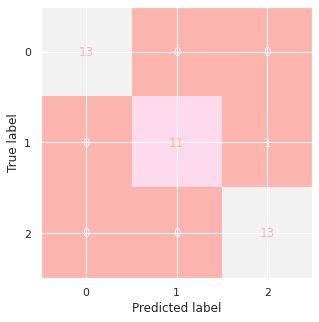

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# 함수 이용해서  도식화
plot_confusion_matrix(
    model, 
    X_test, 
    y_test,
    cmap=plt_cmap[0],
    colorbar=False,
    );

## 3) Accuracy, Precision, recall, f1-Score
- f1-Score는 트레이드 오프 관계에 있는 Precision과 Recall을 종합한 Score
  - Balance 데이터 일때는 Accuracy를 비교하여 모델 선정.
  - imbalance 데이터 일때는 F1 Score를 비교하는 것이 바람직함

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      0.48      0.65        25
         2.0       0.00      0.00      0.00         0

    accuracy                           0.66        38
   macro avg       0.67      0.49      0.55        38
weighted avg       1.00      0.66      0.77        38



## 4) ROC AUC score

In [ ]:
if len(np.unique(y)) == 2:
  auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
else:
  auc_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

print(f'ROC AUC Score: {auc_score}')

ROC AUC Score: 1.0


In [ ]:
if len(np.unique(y)) == 2:
  plot_roc_curve(model, X_test, y_test);

## 5) permutation_importance
- 변수 중요도
- 모델을 학습시킨 뒤, 특정 feature의 데이터를 shuffle 했을 때, 검증 데이터 셋에 대한 예측성능을 확인하여 계산

In [ ]:
from sklearn.inspection import permutation_importance

# 훈련 변수 중요도
result = permutation_importance(
    model,
    X_train,
    y_train,
    scoring = 'f1_micro',
    n_repeats=10,
    random_state=13,
    n_jobs=-1
)
print(result.importances_mean)

# 예측 변수중요도
result = permutation_importance(
    model,
    X_test,
    y_test,
    scoring = 'f1_micro',
    n_repeats=10,
    random_state=13,
    n_jobs=-1
)
print(result.importances_mean)

[0.07053571 0.03928571 0.57589286 0.19732143]
[ 0.05789474 -0.02631579  0.59473684  0.20789474]
